In [1]:
# 1. Module Import 
import numpy as np                              # 선형대수를 위한 NumPy 라이브러리 불러오기
import matplotlib.pyplot as plt                 # 데이터 시각화를 위한 Matplotlib 라이브러리 불러오기

import torch                                    # PyTorch 라이브러리 불러오기 (딥러닝 프레임워크)
import torch.nn as nn                           # 신경망 모델 생성을 위한 모듈 불러오기
import torch.nn.functional as F                 # 활성화 함수 등 신경망 관련 주요 함수들 불러오기
from torchvision import transforms, datasets    # 이미지 데이터 전처리 및 데이터셋 다운로드를 위한 torchvision 모듈 불러오기

In [2]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 

if torch.cuda.is_available():                  # 만약 CUDA(GPU)가 사용 가능하면
    DEVICE = torch.device('cuda')              # 장치를 GPU로 설정
else: 
    DEVICE = torch.device('cpu')              # 그렇지 않으면 장치를 CPU로 설정

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)  # 사용 중인 PyTorch 버전과 선택된 장치 출력



Using PyTorch version: 2.8.0+cu126 Device: cuda


In [3]:
#하이퍼 파라미터 정의 
BATCH_SIZE = 32
EPOCHS = 10


In [4]:
# 3. FashionMNIST 데이터 다운로드(Train set, Test set 분리하기)

train_dataset = datasets.FashionMNIST(
    root      = "../data/FashionMNIST",      # 데이터 저장 경로
    train     = True,                        # 학습용 데이터 여부
    download  = True,                        # 데이터 없으면 다운로드
    transform = transforms.ToTensor()        # 이미지를 텐서로 변환
)

test_dataset = datasets.FashionMNIST(
    root      = "../data/FashionMNIST",      # 데이터 저장 경로
    train     = False,                       # 테스트용 데이터 여부
    transform = transforms.ToTensor()        # 이미지를 텐서로 변환
)

train_loader = torch.utils.data.DataLoader(
    dataset    = train_dataset,              # 학습용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = True                        # 데이터 섞기
)

test_loader = torch.utils.data.DataLoader(
    dataset    = test_dataset,               # 테스트용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = False                       # 순서 유지
)


In [5]:
# 4. 데이터 확인하기 (1)
for (x_train, y_train) in train_loader:                         # 학습용 데이터 로더에서 배치 단위로 데이터를 가져옴
    print('x_train:', x_train.size(), 'type:', x_train.type())  # 입력 이미지 텐서의 크기와 자료형 출력
    print('y_train:', y_train.size(), 'type:', y_train.type())  # 정답 라벨 텐서의 크기와 자료형 출력
    break                                                       # 첫 번째 배치만 확인하고 반복 종료


x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


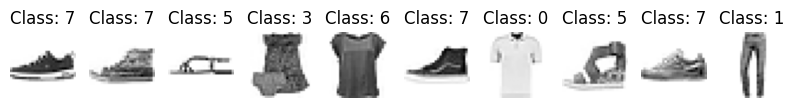

In [6]:
# 5. 데이터 확인하기 (2)
pltsize = 1                                             # 출력 이미지 크기 설정
plt.figure(figsize=(10 * pltsize, pltsize))             # 전체 그림 크기 설정 (가로로 10개 이미지)

for i in range(10):                                     # 처음 10개 이미지에 대해 반복
    plt.subplot(1, 10, i + 1)                           # 1행 10열의 서브플롯 중 i번째 위치
    plt.axis('off')                                     # 축(좌표) 숨기기
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap="grey_r")  # 이미지 출력 (28x28로 변형)
    plt.title('Class: ' + str(y_train[i].item()))       # 해당 이미지의 클래스(숫자 라벨) 표시

In [7]:
# 6. AutoEncoder(AE) 모델 설계하기

class AE(nn.Module):                                 # AutoEncoder 클래스 정의 (PyTorch 신경망 모듈 상속)
    def __init__(self):                              # 초기화 함수 직접 재정의 
        super(AE, self).__init__()                   # 상속받은 부모 클래스도 초기화
        
        self.encoder = nn.Sequential(                # 인코더 정의: 입력 이미지를 잠재 벡터로 압축 & nn.Sequential()을 이용해 인코더 단위를 한번에 정의
            nn.Linear(28 * 28, 512),                 # 입력층: 784 → 512
            nn.ReLU(),                               # 활성화 함수
            nn.Linear(512, 256),                     # 은닉층: 512 → 256
            nn.ReLU(),                               # 활성화 함수
            nn.Linear(256, 32),                      # 잠재층: 256 → 32
        )
        
        self.decoder = nn.Sequential(                # 디코더 정의: 잠재 벡터를 다시 이미지로 복원 & nn.Sequential()을 이용해 디코더 단위를 한번에 정의
            nn.Linear(32, 256),                      # 입력층: 32 → 256
            nn.ReLU(),                               # 활성화 함수
            nn.Linear(256, 512),                     # 은닉층: 256 → 512
            nn.ReLU(),                               # 활성화 함수
            nn.Linear(512, 28 * 28),                 # 출력층: 512 → 784
        )
        
    def forward(self, x):                            # 순전파 함수 (입력 → 인코딩 → 디코딩)
        encoded = self.encoder(x)                    # 인코딩 수행
        decoded = self.decoder(encoded)              # 디코딩 수행
        return encoded, decoded                      # 인코딩 결과와 디코딩 결과 반환
    

In [9]:
# 7. Optimizer(최적화 알고리즘), Objective Function(손실 함수)설정 


model = AE().to(DEVICE)                                    # AE 클래스의 인스턴스를 생성하고, 지정된 DEVICE(GPU 또는 CPU)로 모델을 이동시킴
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 모델의 파라미터를 Adam 최적화 알고리즘으로 업데이트하도록 설정 (학습률 0.001)
criterion = nn.MSELoss()                                   # 손실 함수로 평균 제곱 오차(MSE)를 사용 — 주로 오토인코더나 회귀 문제에서 사용됨
print(model)                                               # 모델 구조를 출력 — 각 층의 구성과 파라미터 정보를 확인할 수 있음

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [ ]:
# 8. AE 모델 학습을 진행하며 학습 데이터 대한 모델 성능을 확인하는 함수 정의 

def train(Epoch, model, train_loader, optimizer, log_interval):   # 한 에폭 동안 모델을 학습시키는 함수
    model.train()                                                 # 모델을 학습 모드로 설정
    for batch_idx, (image, _) in enumerate(train_loader):         # train_loader에 담긴 배치 데이터를 반복하며 학습 수행. 
                                                                  # AE는 입력 데이터를 압축 복원하는 과정에 생성되는 은닉층과, Latent Space안에 존재하는 Feature가 중요
                                                                  # 정답 레이블은 사용하지 않아 (image, _) 로 레이블 부분을 생략함

        image  = image.view(-1, 28*28).to(DEVICE)                 # 입력 이미지를 1차원 벡터로 변환 후 DEVICE로 이동
        target = image.view(-1, 28*28).to(DEVICE)                 # 타깃도 동일하게 변환 (오토인코더는 입력 = 타깃)

        optimizer.zero_grad()                                     # 이전 배치의 gradient 초기화
        encoded, decoded = model(image)                           # 모델에 입력 → 인코딩 & 디코딩 결과 반환
        loss = criterion(decoded, target)                         # 디코딩 결과와 타깃 간의 손실 계산
        loss.backward()                                           # 손실에 대한 역전파 수행
        optimizer.step()                                          # 파라미터 업데이트

        if batch_idx % log_interval == 0:                         # 일정 간격마다 학습 상태 출력
            print(f"Train Epoch: {Epoch} "
                  f"[{batch_idx * len(image)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                  f"Train Loss: {loss.item():.6f}")
        

In [ ]:
#  